# Обучение эмбеддингов (Metric Learning)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
tfds.builder('lfw').info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

## Загрузка и подготовка датасета LFW

In [4]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw',
    split=['train[:99%]','train[99%:]'],
    as_supervised=True,
    with_info = True
)

## Визуализация датасета

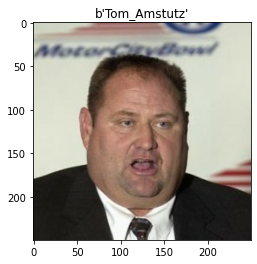

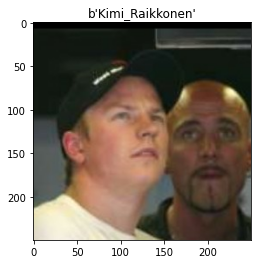

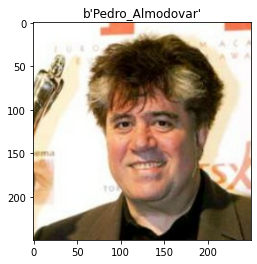

In [5]:
for label, img in train_ds.take(3):
    plt.imshow(img)
    plt.title(label.numpy())
    plt.show()

## Создание модели CNN

In [6]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [7]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, ...]
    embs2 = embs[bs//2:, ...]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [8]:
BATCH_SIZE = 64
NUM_EPOCHS = 4

def normalize_img(label, image):
  return label, tf.cast(image, tf.float32) / 255.

train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

test_ds = test_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(1)

## Подготовка к обучению

In [9]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [10]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print(images.shape)
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

(64, 250, 250, 3)
[0] Loss: 89.3426742553711
(64, 250, 250, 3)
[200] Loss: 0.0
(64, 250, 250, 3)
[400] Loss: 0.0
(64, 250, 250, 3)
[600] Loss: 0.754350483417511
(64, 250, 250, 3)
[800] Loss: 0.0
CPU times: user 2min 7s, sys: 51.4 s, total: 2min 58s
Wall time: 3min 25s


## Получение эмбеддингов для тестовой выборки

In [11]:
test_y = np.array([])
test_embs = tf.concat([model(images) for _, images in test_ds], 0)

for labels, images in test_ds:
    test_y = np.append(test_y, labels.numpy()[0])

In [12]:
test_y.shape

(132,)

## Функция для визуализации эмбеддингов

In [35]:
def draw_embeddings(X_embedded, targets):
    plt.figure(figsize=(10, 10))
    for class_idx in np.unique(targets)[:10]:
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1], label=class_idx)
        plt.legend()
    plt.grid(True)

## Визуализация эмбеддингов в 2D пространстве с помощью TSNE

In [23]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs)
labels_for_viz = test_y

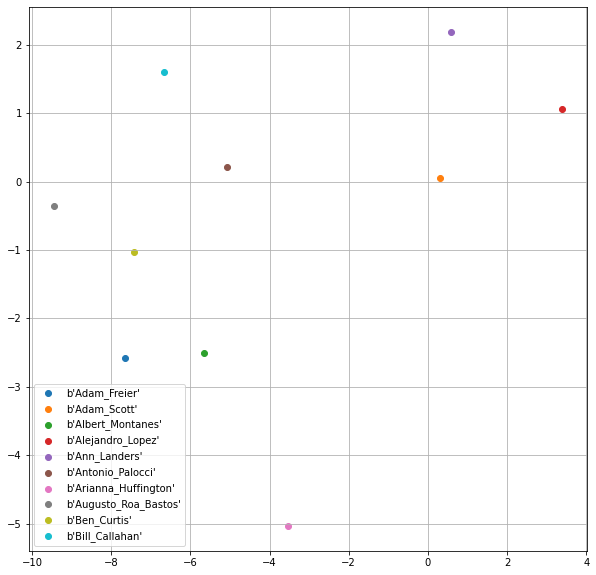

In [36]:
draw_embeddings(test_embs_2D, labels_for_viz)

## Тестирование на новых данных
Картинка из интернета

In [45]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250), order=3, mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img

img_a1 = load_and_prepare_image('/content/TEST-BEN-CURTIS.jpg')

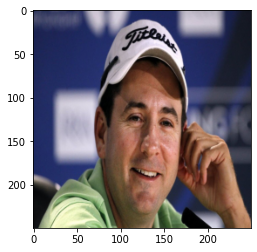

In [46]:
fig = plt.figure(figsize=(12,4))
plt.imshow(img_a1)
plt.show()

## Получение эмбеддингов для новых данных

In [73]:
new_embs = model(np.stack((img_a1,), axis=0))

## Вычисление расстояний между эмбеддингами


In [56]:
ben = np.unique(test_y)[8]
ben

b'Ben_Curtis'

In [82]:
emb_ben = test_embs[np.where(test_y==ben)[0][0],:]
emb_not_ben = test_embs[np.where(test_y!=ben)[0][0],:]

In [83]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5


print('ben_1 <-> ben_2: ', diff(emb_ben, new_embs[0,:]))
print('ben_2 <-> not_ben: ', diff(emb_not_ben, new_embs[0,:]))

ben_1 <-> ben_2:  16.069846287901974
ben_2 <-> not_ben:  21.46201961915077
